In [63]:
pip install kneed

In [64]:
pip install joblib

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import csv
from scipy.fftpack import fft,dct
from scipy.fftpack import ifft,idct
import matplotlib.pyplot as plt
%matplotlib inline
from array import array
import zlib

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.externals.joblib import dump, load
import pickle as pk
from kneed import KneeLocator

In [66]:
# # Get data (Optional approach)
# def get_data_decompo(start,end,block_size,num_var): # block_size=64,512,4096,128*128=16384, 128*3=384
#     iteration=[]
#     for i in range(start,end):
#         #filename='/content/drive/MyDrive/isotropic1024coarse-velocity/isotropic1024coarse-velocity-{}.bin'.format(str(i).zfill(4))
#         filename='/content/drive/My Drive/jhu-channel-velocity/channel-velocity-{}.bin'.format(str(i).zfill(4))
#         x = np.fromfile(filename, dtype='float32') #float
#         iteration.append(x)
#     block_size=len(x)//num_var
#     tot_blocks=len(iteration[0])//block_size
#     y = np.reshape(iteration, (tot_blocks,block_size))
#     yt=pd.DataFrame(y.T)
#     return yt,tot_blocks,block_size

# DCT (2D)
def dct_data(data,tot_blocks):
    new=[]
    for i in range(tot_blocks):
        new.append(dct(data.T.loc[i].values,norm='ortho'))
    row_block_dct=pd.DataFrame(new)
    row_block_dct_t=row_block_dct.T
    return row_block_dct_t
    # x_dct=dct(y_df.T,norm='ortho')
    # x_dct_df=pd.DataFrame(x_dct.T)
    # x_dct_df.columns=x_dct_df.columns.astype('str')   


# iDCT (2D)
def idct_data(data,tot_blocks):
    new=[]
    for i in range(tot_blocks):
        new.append(idct(data.T.loc[i].values,norm='ortho'))
    row_block_idct=pd.DataFrame(new)
    row_block_idct_t=row_block_idct.T
    return row_block_idct_t
    # x_idct=idct(xx.T,norm='ortho')
    # x_idct_t=x_idct.T

# PCA with standardization(Optional approach)
def pca_func(data,k):
    scaler=StandardScaler()
    scaler.fit(data)
    scaled_data=scaler.transform(data)
    X_train = scaled_data
    pca = PCA(n_components=k)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    # explained_variance=pca.explained_variance_
    # explained_variance_ratio=pca.explained_variance_ratio_
    exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
    return exp_var_cumul

# # inverse PCA(Optional approach)
# def inverse_pca(pca_estimator,X_train_pca):
#     X_projected = pca_estimator.inverse_transform(X_train_pca)
#     return X_projected

# Quantization
def quantization(data_quan,bin_number, error_bound):
  gb_up=bin_number*error_bound
  gb_lower=(-1)*bin_number*error_bound
  gb_bin=np.linspace(gb_lower, gb_up, bin_number+1)
  # gb_bin_avg=[]
  # for u in range(0,len(gb_bin)-1):
  #   gb_bin_avg.append((gb_bin[u]+gb_bin[u+1])/2)
  save_exact=[] 
  index_exact=[]
  for x in range(0,len(data_quan)):
    if data_quan[x]>gb_bin[-1] or data_quan[x]<=gb_bin[0]:
        index_exact.append(bin_number)
        save_exact.append(data_quan[x][0])
    else:
        left,right=0,len(gb_bin)-1
        while left<right-1:
          mid=(left+right)//2
          if data_quan[x]<gb_bin[mid]:
            right=mid
          elif data_quan[x]>gb_bin[mid]:
            left=mid
          else:
            break
        if abs(data_quan[x]-(gb_bin[mid]-error_bound))<=abs((gb_bin[mid]+error_bound)-data_quan[x]):
          index_exact.append(mid-1)
        else:
          index_exact.append(mid)
  return save_exact,index_exact#,gb_bin_avg,gb_bin
  
  
def inverse_quantization(index,save_ex,bin_number, error_bound):
  recons=[]
  ind=0
  gb_up=bin_number*error_bound
  gb_lower=(-1)*bin_number*error_bound
  gb_bin=np.linspace(gb_lower, gb_up, bin_number+1)
  for i in range(len(index)):
    if index[i]==bin_number:
      recons.append(save_ex[ind])
      ind+=1
    else:
      recons.append(gb_bin[index[i]])
  return recons


# Evaluation
def rel_error(ori,reconstruct):
    max_abs_error=abs(ori-reconstruct).max()
    data_range=np.max(np.max(ori))-np.min(np.min(ori)) #max(ori)-min(ori)
    rel_error=max_abs_error/data_range
    return rel_error
    
import math
def psnr(ori,reconstruct):
    mse = ((ori - reconstruct) ** 2).mean().mean()
    data_range=np.max(np.max(ori))-np.min(np.min(ori)) #max(ori)-min(ori)
    psnr_res=20*(math.log10(data_range))-10*(math.log10(mse))
    return psnr_res

In [82]:
### Example

## Compression

# Step 1: Read data
filename='/content/drive/MyDrive/CESM-ATM-tylor/1800x3600/CLDHGH_1_1800_3600.dat'# 2D: 1800*3600
x = np.fromfile(filename, dtype='float32') #float
ori=x

# Step 2: Set Parameter
tot_blocks=1800
block_size=3600
bin_number=255 #e.g.,65535 
n_bytes=1 #e.g.,2
precision=4 #float
error_bound=1e-3 #e.g.,1e-4
tot_var_exp=0.9999 # 99.9%:"three-nine"; 99.999999%:"eight-nine"

# Step 3: DCT with decomposition
y=x.reshape((block_size,tot_blocks))
ori_2d=y
y_df=pd.DataFrame(y)
dctdata=dct_data(y_df,tot_blocks)

In [68]:
# Step 4: k-PCA:
# Method 2: total variance explained 
k=tot_blocks
exp_var_cumul=pca_func(dctdata,k)
exp_cum=list(exp_var_cumul)
num_k = next(s for s, val in enumerate(exp_cum) if val > tot_var_exp) 
print("The number of k needed:",num_k)

# # Method 1: knee-point detection
# ind_rand=[i for i in range(0,tot_blocks)]
# kneedle = KneeLocator(ind_rand, exp_var_cumul, S=1.0, curve='concave', direction='increasing', interp_method='interp1d')#e.g.,polynomial
# print("The number of k needed:",kneedle.knee)
# num_k=kneedle.knee

The number of k needed: 226


In [69]:
# Step 5: PCA based on selected k
# pca without standardization
pca = PCA(n_components=num_k)
pca.fit(dctdata)
X_train_pca = pca.transform(dctdata)
pca_estimator=pca
X_train_pca_1d=X_train_pca.reshape((-1,1))
data_quan=X_train_pca_1d

## pca with standardization
# scaler=StandardScaler()
# scaler.fit(dctdata)
# scaled_data=scaler.transform(dctdata)
# X_train = scaled_data
# pca = PCA(n_components=k)
# pca.fit(X_train)
# X_train_pca = pca.transform(X_train)
# X_train_pca_1d=X_train_pca.reshape((-1,1))
# data_quan=X_train_pca_1d
# pk.dump(scaler, open('scaler.pkl', 'wb'))

In [70]:
# Step 6: Quantization
save_exact,index_exact=quantization(data_quan,bin_number, error_bound)

In [71]:
# Step 7: Encoding
pk.dump(pca_estimator, open("pca.pkl","wb"))

output_file = open('save_exact.bin', 'wb')
float_array = array('f', save_exact) #single-precision(f)
float_array.tofile(output_file)
output_file.close()

output_file = open('index_exact.bin', 'wb')
float_array = array('H',index_exact) #unsigned char(B) or unsigned shor (H)
float_array.tofile(output_file)
output_file.close()

In [72]:
# Step 8: Zlib
original_exact = open('save_exact.bin', 'rb').read()
original_index = open('index_exact.bin', 'rb').read()
compressed_exact = zlib.compress(original_exact, zlib.Z_BEST_COMPRESSION)
compressed_index = zlib.compress(original_index, zlib.Z_BEST_COMPRESSION)

In [73]:
## Compression Ratio
print('CR:', float(len(ori)*precision)/(float(len(compressed_exact)+len(compressed_index))))
print('bit-rate:', precision*8/(float(len(ori)*precision)/(float(len(compressed_exact)+len(compressed_index)))))

CR: 47.95630647632157
bit-rate: 0.6672740740740741


In [74]:
## Decompression

# Step 1: Decode, set parameter
filename='/content/index_exact.bin'
index_recons = np.fromfile(filename, dtype='H') #unsigned char(B) or unsigned shor (H)
filename='/content/save_exact.bin'
save_recons = np.fromfile(filename, dtype='float32') #float32
pca_reload = pk.load(open("pca.pkl",'rb'))
#sc=pk.load('std_scaler.bin') #scaler
recons=[]

In [75]:
# Step 2: Inverse Quantization
recons=inverse_quantization(index_recons,save_recons,bin_number, error_bound)
X_train_pca_compressed=np.array(recons).reshape((-1,num_k))

# Step 3: Inverse PCA & DCT
X_projected_quan=pca_reload.inverse_transform(X_train_pca_compressed)
# if use Standardize PCA, include:
# X_projected_quan = sc.inverse_transform(X_projected_quan)
x_ipca_df=pd.DataFrame(X_projected_quan)
recon_data=idct_data(x_ipca_df,tot_blocks)
decompressed=recon_data.to_numpy().flatten()

In [76]:
## PSNR
print("PSNR:",psnr(ori,decompressed))

PSNR: 50.5069776995626


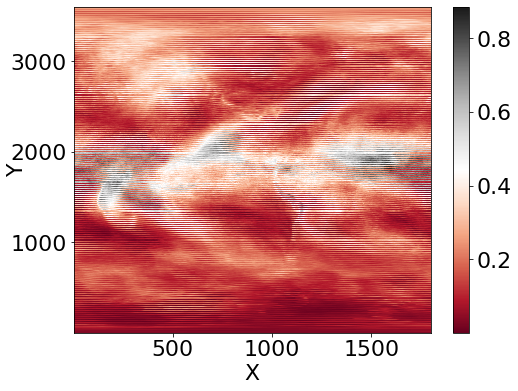

In [85]:
## Visualization 2D dataset
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
import matplotlib.pyplot as plt
def tickformat(x):
    if int(x) == float(x):
        return str(int(x))
    else:
        return str(x)
fig,ax=plt.subplots(figsize=(8,6))
rcParams['font.family'] = "Arial"# sans-serif
ax.tick_params(labelsize=22)
ax.ticklabel_format(axis='x')
ax.set_xlabel("X",fontsize=22)#fontname='Arial'
ax.set_ylabel("Y",fontsize=22)#fontname='Arial'
#ax.set_ylim([-5.1,5.1])
#ax.set_xlim([0,3600])

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#from matplotlib.patches import Patch
from matplotlib.lines import Line2D
x = np.linspace(1, 1800,1800)
y = np.linspace(1, 3600, 3600)
X, Y = np.meshgrid(x, y)
Z=ori_2d #error_2d
mesh = ax.pcolormesh(X,Y, Z, cmap = 'RdGy')
#mesh.set_clim(-0.01,0.01)

cb=fig.colorbar(mesh,ax=ax)
cb.ax.tick_params(labelsize=22)
# custom_lines = [#mpatches.Patch(color='orangered',label='Abnormal'),
#                #mpatches.Patch(color='steelblue',label='Normal'),
#                 Line2D([0], [0], color='darkgreen',linestyle='',label='DCT_PCA',linewidth=4.0),
#                 #Line2D([0], [0], color='orangered',linestyle='-',label='Reconstructed Datasets'),
#                 #Line2D([0], [0], color='k',linestyle='--',label='Local maxima')
#                ]
# ax.legend(handles=custom_lines,loc="upper right",prop={'size': 48},frameon=False)
ax.yaxis.set_label_coords(-0.13,0.5)
#plt.savefig('ori2d.png', format='png',dpi=600)
plt.show()

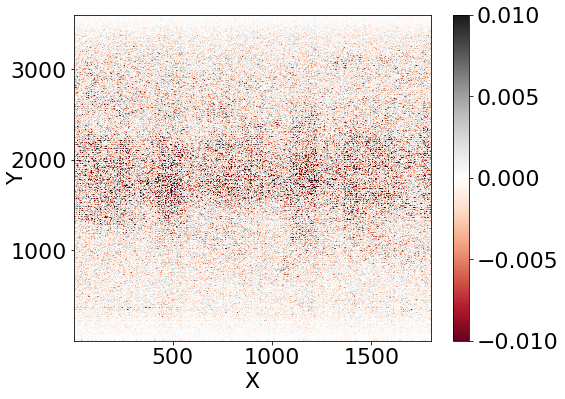

In [86]:
## Visualization compression error
error=pd.DataFrame((ori-decompressed).T)
error_2d=error.to_numpy().reshape((block_size,tot_blocks))
fig,ax=plt.subplots(figsize=(8,6))
rcParams['font.family'] = "Arial"# sans-serif
ax.tick_params(labelsize=22)
ax.ticklabel_format(axis='x')
ax.set_xlabel("X",fontsize=22)#fontname='Arial'
ax.set_ylabel("Y",fontsize=22)#fontname='Arial'
x = np.linspace(1, 1800,1800)
y = np.linspace(1, 3600, 3600)
X, Y = np.meshgrid(x, y)
Z=error_2d
mesh = ax.pcolormesh(X,Y, Z, cmap = 'RdGy')
mesh.set_clim(-0.01,0.01)

cb=fig.colorbar(mesh,ax=ax)
cb.ax.tick_params(labelsize=22)
ax.yaxis.set_label_coords(-0.13,0.5)
#plt.savefig('err.png', format='png',dpi=600)
plt.show()